In [2]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [3]:
import sys

# Add the current folder to sys.path
sys.path.append(os.path.abspath(''))

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4")

In [5]:
from langchain_core.documents import Document


documents = [
    Document(
        page_content=(
            "Ever since I lost my job last year, I've been struggling to find my footing. "
            "Every day feels like a challenge, waking up with no sense of purpose or direction. "
            "I’ve tried applying for countless jobs, but the constant rejections have left me feeling inadequate. "
            "Talking to my friends helps sometimes, but I often feel like a burden when I share my feelings."
        ),
        metadata={"user_id": "user_1", "topic": "job loss, depression"}
    ),
    Document(
        page_content=(
            "My battle with social anxiety has taken over my life. Going to the grocery store feels like climbing a mountain. "
            "Even simple interactions, like saying hello to a neighbor, send my heart racing. "
            "I've been avoiding social gatherings for months now, and the loneliness is unbearable. "
            "Recently, I started therapy, and while it’s hard, I’m hopeful it might help."
        ),
        metadata={"user_id": "user_2", "topic": "social anxiety, loneliness"}
    ),
    Document(
        page_content=(
            "Losing my mother to cancer was the hardest thing I've ever faced. She was my rock, my guide in life. "
            "Every day, I feel the weight of her absence, and it’s difficult to move forward. "
            "I’ve tried journaling my thoughts and emotions, and while it brings a bit of relief, the pain is still overwhelming. "
            "Sometimes, I just sit in her favorite chair and imagine she’s still here."
        ),
        metadata={"user_id": "user_3", "topic": "grief, loss"}
    ),
    Document(
        page_content=(
            "For years, I’ve felt like a failure. I dropped out of college and have been working odd jobs ever since. "
            "Seeing my friends succeed while I feel stuck has been incredibly tough. "
            "I’ve been trying to learn new skills online, but it feels like an uphill battle. "
            "Some days, I wonder if I’ll ever find my way or make my family proud."
        ),
        metadata={"user_id": "user_4", "topic": "self-doubt, failure"}
    ),
    Document(
        page_content=(
            "After my divorce, life has felt like a blur. I lost not only my partner but also the sense of security and routine we built together. "
            "I’ve been trying to focus on myself, picking up hobbies like painting and hiking, but the loneliness creeps in. "
            "Talking to my kids helps me stay grounded, but the nights are especially hard."
        ),
        metadata={"user_id": "user_5", "topic": "divorce, loneliness"}
    ),
    Document(
        page_content=(
            "Depression has been my constant companion for as long as I can remember. Some days, it feels like a fog I can’t escape. "
            "I’ve tried medication, therapy, and even exercise, but nothing seems to make a lasting difference. "
            "My friends and family try to help, but I feel like no one truly understands what it’s like to live like this."
        ),
        metadata={"user_id": "user_6", "topic": "chronic depression"}
    ),
    Document(
        page_content=(
            "Being a single parent is the hardest job I’ve ever had. Between work, taking care of my child, and managing a household, "
            "I barely have time to breathe. I feel immense guilt for not being able to give my child everything they deserve. "
            "Sometimes, I cry myself to sleep, wondering if I’m doing enough."
        ),
        metadata={"user_id": "user_7", "topic": "parenting, stress"}
    ),
    Document(
        page_content=(
            "A few years ago, I suffered a severe injury that left me in chronic pain. The physical discomfort is one thing, "
            "but the emotional toll has been just as debilitating. I’ve had to give up hobbies I loved, like running and playing sports. "
            "Every day feels like a battle, but I try to focus on the little victories, like being able to take a short walk."
        ),
        metadata={"user_id": "user_8", "topic": "chronic pain, emotional toll"}
    ),
    Document(
        page_content=(
            "I’ve always struggled with self-esteem, but it’s gotten worse recently. Seeing everyone on social media living their best lives "
            "makes me feel like I’m not enough. I’ve been comparing myself to others, and it’s exhausting. "
            "I started journaling and trying to limit my screen time, but it’s hard to break out of this cycle."
        ),
        metadata={"user_id": "user_9", "topic": "self-esteem, comparison"}
    ),
    Document(
        page_content=(
            "The pandemic left me feeling isolated and disconnected from the world. Working remotely has its perks, "
            "but I miss the daily interactions with my colleagues. I’ve started taking evening walks to clear my mind, "
            "but the sense of loneliness is hard to shake. Video calls just aren’t the same as being with people in person."
        ),
        metadata={"user_id": "user_10", "topic": "isolation, pandemic"}
    ),
]


In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 20,
    length_function = len
)

split_docs = splitter.split_documents(documents)
split_docs

[Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content="Ever since I lost my job last year, I've been struggling to find my footing. Every day feels like a"),
 Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='day feels like a challenge, waking up with no sense of purpose or direction. I’ve tried applying'),
 Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='I’ve tried applying for countless jobs, but the constant rejections have left me feeling'),
 Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='left me feeling inadequate. Talking to my friends helps sometimes, but I often feel like a burden'),
 Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='feel like a burden when I share my feelings.'),
 Document(metadata={'user_id': 'user_2', 'topic': 'social anxiety, loneliness'}, page_content='My battle with s

In [7]:
from collections import defaultdict

grouped_chunks = defaultdict(list)
for chunk in split_docs:
    user_id = chunk.metadata["user_id"]
    grouped_chunks[user_id].append(chunk)

user_list_doc = list(grouped_chunks.values())

In [8]:
user_list_doc

[[Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content="Ever since I lost my job last year, I've been struggling to find my footing. Every day feels like a"),
  Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='day feels like a challenge, waking up with no sense of purpose or direction. I’ve tried applying'),
  Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='I’ve tried applying for countless jobs, but the constant rejections have left me feeling'),
  Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='left me feeling inadequate. Talking to my friends helps sometimes, but I often feel like a burden'),
  Document(metadata={'user_id': 'user_1', 'topic': 'job loss, depression'}, page_content='feel like a burden when I share my feelings.')],
 [Document(metadata={'user_id': 'user_2', 'topic': 'social anxiety, loneliness'}, page_content='My battle

In [9]:
data_user = []

for user_list in user_list_doc:
    
    user_id = user_list[0].metadata["user_id"]
    user_topic = user_list[0].metadata["topic"]
    user_list_doc = user_list
    dict_data = {"user_id": user_id, "user_topic": user_topic, "user_list_doc": user_list_doc}
    data_user.append(dict_data)


In [10]:
import pandas as pd

data_user = pd.DataFrame(data_user)
data_user

,user_id,user_topic,user_list_doc
0,user_1,"job loss, depression",[page_content='Ever since I lost my job last y...
1,user_2,"social anxiety, loneliness",[page_content='My battle with social anxiety h...
2,user_3,"grief, loss",[page_content='Losing my mother to cancer was ...
3,user_4,"self-doubt, failure","[page_content='For years, I’ve felt like a fai..."
4,user_5,"divorce, loneliness","[page_content='After my divorce, life has felt..."
5,user_6,chronic depression,[page_content='Depression has been my constant...
6,user_7,"parenting, stress",[page_content='Being a single parent is the ha...
7,user_8,"chronic pain, emotional toll","[page_content='A few years ago, I suffered a s..."
8,user_9,"self-esteem, comparison",[page_content='I’ve always struggled with self...
9,user_10,"isolation, pandemic",[page_content='The pandemic left me feeling is...


In [11]:
from graph_user import create_app

app = create_app()

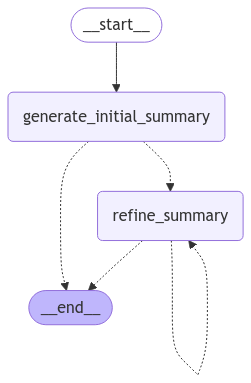

In [12]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [13]:
output = []

for i in range(len(data_user)):
    
    documents = data_user["user_list_doc"][i]  
    state = await app.ainvoke({"contents": [doc.page_content for doc in documents], "extra_args": {"llm": llm}})
    
    summary_document = Document(
        page_content=state["summary"], 
        metadata={"user_id": data_user["user_id"][i], "topic_user": data_user["user_topic"][i]} 
    )
    output.append(summary_document)  

data_user["user_summary_profile"] = output

CancelledError: 

In [26]:
output

[Document(metadata={'user_id': 'user_1', 'topic_user': 'job loss, depression'}, page_content='The speaker is grappling with feelings of purposelessness and inadequacy due to job loss and repeated rejections in their job search. Despite initially finding some comfort in conversations with friends, they now feel like a burden when they share their feelings, further intensifying their struggle.'),
 Document(metadata={'user_id': 'user_2', 'topic_user': 'social anxiety, loneliness'}, page_content='The author, battling severe social anxiety that drastically impacts their daily activities and relationships, experiences intense loneliness due to avoidance of social gatherings. Recently, they have begun therapy to manage their condition. Despite acknowledging the difficulty of the process, the author expresses a sense of hope that this therapeutic intervention might yield positive results.'),
 Document(metadata={'user_id': 'user_3', 'topic_user': 'grief, loss'}, page_content="The author is deep

In [27]:
from chromadb.config import Settings
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

# Enable resetting the database in the settings
settings = Settings(
    allow_reset=True,
    persist_directory="./chromadb"  # Specify persistence directory if needed
)

# Initialize OpenAI embeddings
embedding_function = OpenAIEmbeddings()

# Create a Chroma instance with the settings
db = Chroma(
    collection_name="my_collection",
    embedding_function=embedding_function,
    client_settings=settings
)

print("Chroma database initialized successfully!")

C:\Users\amine\AppData\Local\Temp\ipykernel_14040\3489121081.py:12: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_function = OpenAIEmbeddings()
C:\Users\amine\AppData\Local\Temp\ipykernel_14040\3489121081.py:15: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


Chroma database initialized successfully!


In [28]:
db.add_documents(output)

['2440bffe-b1ec-432f-9cde-a94f557a0614',
 'a9d44919-b89f-4cad-87f5-788c3d3da8f4',
 '4924b14e-96c5-450c-8922-a69b96b7f852',
 '2b4ce92f-fdba-4488-a8d8-701bfe98398d',
 '5de5dce4-7a16-46fa-8bc7-4e0a73b541db',
 '49bfb556-7394-417d-bb17-921eaff2549c',
 '0e90af57-c758-4436-922a-8ad1ebc974d5',
 '5bf0d2ed-c4bc-424d-9660-f61a96a7ef97',
 '04024851-573e-49c9-acc7-e09fb933bf90',
 'c0e0683d-f83f-4b38-9e2a-e06cd8981b03']

In [29]:
similarity_profile_docs = []

for i in range(len(data_user)):
    current_user_id = data_user["user_id"][i]
    query = data_user["user_summary_profile"][i].page_content
    docs = db.similarity_search(query = query,
                                filter = {"user_id": {"$ne": current_user_id}})
    similarity_profile_docs.append(docs)

data_user["similar_profile"] = similarity_profile_docs

In [30]:
data_user["similar_profile"][9]

[Document(metadata={'topic_user': 'social anxiety, loneliness', 'user_id': 'user_2'}, page_content='The author, battling severe social anxiety that drastically impacts their daily activities and relationships, experiences intense loneliness due to avoidance of social gatherings. Recently, they have begun therapy to manage their condition. Despite acknowledging the difficulty of the process, the author expresses a sense of hope that this therapeutic intervention might yield positive results.'),
 Document(metadata={'topic_user': 'job loss, depression', 'user_id': 'user_1'}, page_content='The speaker is grappling with feelings of purposelessness and inadequacy due to job loss and repeated rejections in their job search. Despite initially finding some comfort in conversations with friends, they now feel like a burden when they share their feelings, further intensifying their struggle.'),
 Document(metadata={'topic_user': 'self-doubt, failure', 'user_id': 'user_4'}, page_content="The author

In [31]:
data_user

,user_id,user_topic,user_list_doc,user_summary_profile,similar_profile
0,user_1,"job loss, depression",[page_content='Ever since I lost my job last y...,page_content='The speaker is grappling with fe...,[page_content='The author continues to express...
1,user_2,"social anxiety, loneliness",[page_content='My battle with social anxiety h...,"page_content='The author, battling severe soci...",[page_content='The author discloses their ongo...
2,user_3,"grief, loss",[page_content='Losing my mother to cancer was ...,page_content='The author is deeply grieving th...,[page_content='The author has been coping with...
3,user_4,"self-doubt, failure","[page_content='For years, I’ve felt like a fai...",page_content='The author continues to express ...,[page_content='The speaker is grappling with f...
4,user_5,"divorce, loneliness","[page_content='After my divorce, life has felt...",page_content='The individual is navigating lif...,[page_content='The author continues to express...
5,user_6,chronic depression,[page_content='Depression has been my constant...,page_content='The author discloses their ongoi...,"[page_content='The author, battling severe soc..."
6,user_7,"parenting, stress",[page_content='Being a single parent is the ha...,page_content='Between managing household chore...,[page_content='The individual is navigating li...
7,user_8,"chronic pain, emotional toll","[page_content='A few years ago, I suffered a s...",page_content='The author has been coping with ...,"[page_content='The author, battling severe soc..."
8,user_9,"self-esteem, comparison",[page_content='I’ve always struggled with self...,page_content='The author is struggling with lo...,"[page_content='The author, battling severe soc..."
9,user_10,"isolation, pandemic",[page_content='The pandemic left me feeling is...,page_content='Despite attempts to cope with ch...,"[page_content='The author, battling severe soc..."


Chroma instance deleted from memory.
